***Task 1: Advanced Exploratory Data Analysis (EDA) & Feature Engineering***

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn 
from datetime import datetime

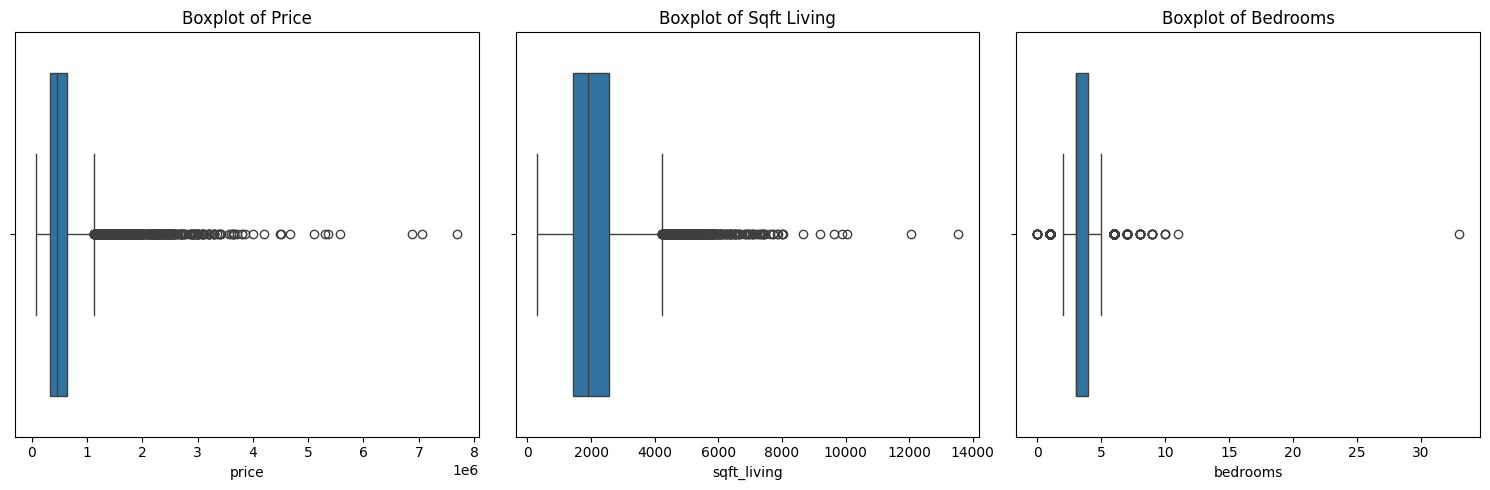

           id       date     price  bedrooms  bathrooms  sqft_living  \
0  7129300520 2014-10-13  221900.0         3       1.00         1180   
1  6414100192 2014-12-09  538000.0         3       2.25         2570   
2  5631500400 2015-02-25  180000.0         2       1.00          770   
3  2487200875 2014-12-09  604000.0         4       3.00         1960   
4  1954400510 2015-02-18  510000.0         3       2.00         1680   

   sqft_lot  floors  waterfront  view  ...     long  sqft_living15  \
0    5650.0     1.0           0     0  ... -122.257           1340   
1    7242.0     2.0           0     0  ... -122.319           1690   
2   10000.0     1.0           0     0  ... -122.233           2720   
3    5000.0     1.0           0     0  ... -122.393           1360   
4    8080.0     1.0           0     0  ... -122.045           1800   

   sqft_lot15  sale_year  sale_month  house_age  was_renovated  \
0        5650       2014          10         59              0   
1        7639 

C:\Users\RAM PRAHASITH\AppData\Local\Temp\ipykernel_19620\2594043123.py:66: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['floors'].replace(0, np.nan, inplace=True)
C:\Users\RAM PRAHASITH\AppData\Local\Temp\ipykernel_19620\2594043123.py:67: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a

In [ ]:
# Loading the King County house price dataset
df = pd.read_csv("C:/Users/RAM PRAHASITH/OneDrive/Desktop/F ML/data-preprocessing-and-regression-with-scikit-learn-Prahas2001/kc_house_data.csv")

# 1. Introducing 5% missing data randomly in sqft_lot and bathrooms

np.random.seed(42)
for col in ['sqft_lot', 'bathrooms']:
    n_missing = int(0.05 * len(df))
    missing_indices = np.random.choice(df.index, n_missing, replace=False)
    df.loc[missing_indices, col] = np.nan

# 2. Outlier Detection and Removal
plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
sns.boxplot(x=df['price'])
plt.title('Boxplot of Price')

plt.subplot(1,3,2)
sns.boxplot(x=df['sqft_living'])
plt.title('Boxplot of Sqft Living')

plt.subplot(1,3,3)
sns.boxplot(x=df['bedrooms'])
plt.title('Boxplot of Bedrooms')

plt.tight_layout()
plt.show()

for col in ['price', 'sqft_living', 'bedrooms']:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]


# 3. Feature Engineering 
df['date'] = pd.to_datetime(df['date'])


df['sale_year'] = df['date'].dt.year
df['sale_month'] = df['date'].dt.month


df['house_age'] = df['sale_year'] - df['yr_built']


df['was_renovated'] = np.where(df['yr_renovated'] != 0, 1, 0)


df['age_since_renovation'] = np.where(df['was_renovated'] == 1, df['sale_year'] - df['yr_renovated'], df['house_age'])


df['floors'].replace(0, np.nan, inplace=True)
df['bedrooms'].replace(0, np.nan, inplace=True)

df['sqft_living_per_floor'] = df['sqft_living'] / df['floors']
df['sqft_living_per_floor'].fillna(0, inplace=True)  

df['bath_per_bed'] = df['bathrooms'] / df['bedrooms']
df['bath_per_bed'].fillna(0, inplace=True)


print(df.head())


***Task 2: Build a Sophisticated Preprocessing Pipeline***

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

numerical_features = ['sqft_living', 'house_age', 'sqft_lot', 'bathrooms','sqft_living_per_floor', 'bath_per_bed', 'age_since_renovation']

categorical_features = ['zipcode']

passthrough_features = ['grade', 'condition', 'was_renovated', 'sale_year', 'sale_month']


numerical_pipeline = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')), ('scaler', StandardScaler())])

categorical_pipeline = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(transformers=[('num', numerical_pipeline, numerical_features), ('cat', categorical_pipeline, categorical_features), ('pass', 'passthrough', passthrough_features)])


***Task 3: Model Training and Hyperparameter Tuning***

In [18]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

X = df.drop(columns=['price', 'date'])
y = df['price']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Defining models 
models = {
    'GradientBoosting': GradientBoostingRegressor(random_state=42),
    'RandomForest': RandomForestRegressor(random_state=42),
    'XGBoost': XGBRegressor(random_state=42, objective='reg:squarederror'),
    'LinearRegression': LinearRegression()}

# Hyperparameter tuning
param_grids = {
    'GradientBoosting': {'regressor__n_estimators': [100, 200],'regressor__max_depth': [3, 5]},
    'RandomForest': {'regressor__n_estimators': [100, 200], 'regressor__max_depth': [None, 10]},
    'XGBoost': {'regressor__n_estimators': [100, 200], 'regressor__max_depth': [3, 6]},
    'LinearRegression': {}
    }

best_models = {}

for name, model in models.items():
    print(f"Training and tuning {name}...")
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', model)])
    
    grid_search = GridSearchCV(pipeline, param_grids[name], cv=3, n_jobs=-1, scoring='neg_mean_squared_error')
    grid_search.fit(X_train, y_train)
    best_models[name] = grid_search
    if param_grids[name]:
        print(f"Best parameters for {name}: {grid_search.best_params_}")
    else:
        print(f"No hyperparameters to tune for {name}.")


Training and tuning GradientBoosting...
Best parameters for GradientBoosting: {'regressor__max_depth': 5, 'regressor__n_estimators': 200}
Training and tuning RandomForest...
Best parameters for RandomForest: {'regressor__max_depth': None, 'regressor__n_estimators': 200}
Training and tuning XGBoost...
Best parameters for XGBoost: {'regressor__max_depth': 3, 'regressor__n_estimators': 200}
Training and tuning LinearRegression...
No hyperparameters to tune for LinearRegression.


***Task 4: Evaluation and Interpretation***

In [19]:
results = []

for name, gs in best_models.items():
    y_pred = gs.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results.append({'Model': name, 'RMSE': rmse, 'MAE': mae, 'R2': r2})
    print(f"{name} - RMSE: {rmse:.2f}, MAE: {mae:.2f}, R2: {r2:.2f}")

results_df = pd.DataFrame(results).sort_values('RMSE')
print(f"\nBest overall model: {results_df.iloc[0]['Model']}")

best_model_name = results_df.iloc[0]['Model']



GradientBoosting - RMSE: 86747.26, MAE: 62182.35, R2: 0.82
RandomForest - RMSE: 95608.17, MAE: 67220.27, R2: 0.78
XGBoost - RMSE: 81600.60, MAE: 58259.70, R2: 0.84
LinearRegression - RMSE: 87296.72, MAE: 63697.06, R2: 0.82

Best overall model: XGBoost
